In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import builtins
import keras
import tensorflow as tf
from keras import backend as K
from extra_keras_metrics import average_precision_at_k
from IPython.display import SVG
from keras.utils.vis_utils import plot_model
import pydot as pyd
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense, Embedding, Lambda, Reshape, Flatten, Average
from keras.models import Model
from keras.backend import mean, max
from keras.preprocessing.sequence import pad_sequences

keras.utils.vis_utils.pydot = pyd

In [4]:
import data_generator

In [5]:
tf.__version__

'1.13.1'

In [6]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [7]:
class RecoDNN():
    
    def __init__(self, max_transaction_history = 50, max_product_click_history = 50, max_promotion_click_history = 50,
                 category_size = 100, single_categorical_features = None, numeric_features_size = 10,
                 hidden_layer1_size = 256, hidden_layer2_size = 128, hidden_layer3_size = 64, activation='relu',
                input_embedding_size = 128):
        
        self.max_transaction_history = max_transaction_history
        self.max_product_click_history = max_product_click_history
        self.max_promotion_click_history = max_promotion_click_history
        self.category_size = category_size
        self.hidden_layer1_size = hidden_layer1_size
        self.hidden_layer2_size = hidden_layer2_size
        self.hidden_layer3_size = hidden_layer3_size
        self.single_categorical_features = single_categorical_features
        self.numeric_features_size = numeric_features_size
        self.activation = activation
        self.input_embedding_size = input_embedding_size
        
        self.category_embeddings = tf.keras.layers.Embedding(output_dim=self.input_embedding_size, input_dim = self.category_size, 
                       input_length = builtins.max(self.max_transaction_history, self.max_product_click_history, self.max_promotion_click_history), mask_zero=True, name='category_embeddings')
        
        self.build()
        
    
    def build(self):
        
        inp_layer, inp_embed = self.create_input()
        
        v = tf.keras.layers.Dense(self.hidden_layer1_size, activation = self.activation)(tf.keras.layers.concatenate(inp_embed)) 
        v = tf.keras.layers.Dense(self.hidden_layer2_size, activation = self.activation)(v)
        v = tf.keras.layers.Dense(self.hidden_layer3_size, activation = self.activation, name='user_embedding')(v)
        output = tf.keras.layers.Dense(self.category_size, activation ='softmax', name='softmax_layer')(v)
        self.model = tf.keras.models.Model(inputs = inp_layer, outputs = [output])    
        
    
    def create_input(self):
        
        transaction_cols = [x for x in range(self.max_transaction_history)]
        product_click_cols = [x for x in range(self.max_product_click_history)]
        promotion_click_cols = [x for x in range(self.max_promotion_click_history)]
        seq_category_cols = [transaction_cols, product_click_cols, promotion_click_cols]
        
        seqs = []
        for i, grp in enumerate(seq_category_cols):
            seqs.append(self.seq_categorical_input('seq_categorical_' + str(i), len(grp)))

        singles = []
        if self.single_categorical_features:
            for col in self.single_categorical_features:
                singles.append(self.singe_categorical_input(str(col), self.single_categorical_features[col]))

        nums = self.continous_inputs(self.numeric_features_size)

        inp_layer =  [s[0] for s in seqs]
        inp_layer += [s[0] for s in singles]
        inp_layer.append(nums[0])
        inp_embed = [s[1] for s in seqs]
        inp_embed += [s[1] for s in singles]
        inp_embed.append(nums[1])
               
        return inp_layer, inp_embed
    
    
    def seq_categorical_input(self, name, max_history):
    
        seq = tf.keras.layers.Input(shape=(max_history,), dtype='int32', name=name)
        input_embeddings = self.category_embeddings(seq)
        avg = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1), name= name + '_avg_embedding')
        #avg_embedding = tf.reduce_mean(input_embeddings, axis=0), name= name + '_avg_embedding'))
        avg_embedding = avg(input_embeddings)

        #maxf = Lambda(lambda x: max(x, axis=1), name = name + '_max_embedding')
        #max_embedding = maxf(input_embeddings)

        return seq, avg_embedding   #keras.layers.add([avg_embedding, max_embedding])

    
    def singe_categorical_input(self, name, unique_size):
        single = tf.keras.layers.Input(shape=(1,), dtype='int32', name=name)
        embeddings = tf.keras.layers.Embedding(output_dim = self.input_embedding_size, input_dim = unique_size, 
                           input_length=1, name=name + '_embedding')(single)
        embeddings = tf.keras.layers.Flatten(name = 'flatten_' + name)(embeddings)
        return single, embeddings
    
    def continous_inputs(self, size=None, name='numeric'):
        inp = tf.keras.layers.Input(shape=(size,), dtype='float32', name=name)
        return inp, inp


# fake dataset

In [8]:
data_size = 10000
max_transaction_history = 50
max_product_click_history = 50
max_promotion_click_history = 50
input_embedding_size = 128
category_size = 100
numeric_size = 10

data1 = np.random.randint(category_size, size=(data_size, max_transaction_history))
data2 = np.random.randint(category_size, size=(data_size, max_product_click_history))
data3 = np.random.randint(category_size, size=(data_size, max_promotion_click_history))
inputs = [data1, data2, data3]

single_category_cols = {105:3,106:5,107:10}   ## such as location : unique_value_size
for k in single_category_cols:
    inputs.append(np.random.randint(single_category_cols[k], size=(data_size, 1)))

num1 = np.random.random(size=(data_size, numeric_size))
inputs.append(num1)

labels = np.random.randint(category_size, size=(data_size, 1))
one_hot_labels = keras.utils.to_categorical(labels, num_classes=category_size)


## save locally

In [7]:
inputs1 = inputs.copy()
inputs1.append(labels)
merge = np.hstack(inputs1)
np.savetxt('../data/features.csv', merge, fmt="%2.3f")

In [496]:
# create tfrecord file for test
output_filename = "../data/tf.tfrecord"

def float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list(value)))

with tf.python_io.TFRecordWriter(output_filename) as writer:
    for (v1,v2,v3,v4,v5,v6,v7,v8) in zip(data1, data2, data3, inputs[3], inputs[4], inputs[5], inputs[6], one_hot_labels):
        features = {'seq_categorical_0': int64_feature(v1), 'seq_categorical_1': int64_feature(v2),
                    'seq_categorical_2': int64_feature(v3),'105': int64_feature(v4),
                    '106': int64_feature(v5),'107': int64_feature(v6), 'numeric': float_feature(v7),
                    'labels': float_feature(v8)}
        tf_example = tf.train.Example(features=tf.train.Features(feature=features))
        writer.write(tf_example.SerializeToString())



In [427]:
def parse_function(example_proto):
    features = {"seq_categorical_0":tf.FixedLenFeature([50],tf.int64),
                "seq_categorical_1":tf.FixedLenFeature([50], tf.int64),
                "seq_categorical_2":tf.FixedLenFeature([50], tf.int64),
                "105":tf.FixedLenFeature([1], tf.int64),
                "106":tf.FixedLenFeature([1], tf.int64),
                "107":tf.FixedLenFeature([1], tf.int64),
                "numeric":tf.FixedLenFeature([10], tf.float32),
                "labels":tf.FixedLenFeature([100], tf.float32),
         }
    parsed_features = tf.parse_single_example(example_proto, features)
    #return parsed_features
    return (parsed_features["seq_categorical_0"], parsed_features["seq_categorical_1"], parsed_features["seq_categorical_2"], parsed_features["105"], parsed_features["106"], parsed_features["107"], parsed_features["numeric"]), parsed_features["labels"]

In [497]:
#debug generated tfrecord
try:
    for i, str_rec in enumerate(tf.python_io.tf_record_iterator("../data/tf.tfrecord")):
        example = tf.train.Example()
        example.ParseFromString(str_rec)
        #print(i, dict(example.features.feature).keys())
except:
    print(i)

In [498]:
ds3=tf.data.TFRecordDataset('../data/tf.tfrecord')

In [499]:
ds3=ds3.map(parse_function)

In [500]:
ds3 = ds3.repeat()  # Repeat the input indefinitely.
ds3 = ds3.batch(32)
#iterator = ds3.make_initializable_iterator()

In [501]:
#iterator.get_next()

In [502]:
ds3.output_shapes

((TensorShape([Dimension(None), Dimension(50)]),
  TensorShape([Dimension(None), Dimension(50)]),
  TensorShape([Dimension(None), Dimension(50)]),
  TensorShape([Dimension(None), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(10)])),
 TensorShape([Dimension(None), Dimension(100)]))

In [296]:
ds2=tf.data.Dataset.from_tensor_slices(
    ({'seq_categorical_0': data1, 'seq_categorical_1': data2, 'seq_categorical_2': data3, 
     '105': inputs[3], '106': inputs[4],'107': inputs[5],'numeric': inputs[6]},
     {'softmax_layer': one_hot_labels}))


In [297]:
ds2=ds2.repeat()
ds2=ds2.batch(32)

In [42]:
labels.shape

(10000, 1)

In [163]:
input_dataset = tf.data.Dataset.from_tensor_slices((data1, data2, data3, inputs[3], inputs[4], inputs[5], num1))

In [164]:
input_dataset.output_shapes

(TensorShape([Dimension(50)]),
 TensorShape([Dimension(50)]),
 TensorShape([Dimension(50)]),
 TensorShape([Dimension(1)]),
 TensorShape([Dimension(1)]),
 TensorShape([Dimension(1)]),
 TensorShape([Dimension(10)]))

In [165]:
output_dataset = tf.data.Dataset.from_tensor_slices((one_hot_labels))

In [166]:
output_dataset.output_shapes

TensorShape([Dimension(100)])

In [167]:
input_dataset = input_dataset.batch(32).repeat()
output_dataset = output_dataset.batch(32).repeat()

In [168]:
dataset = tf.data.Dataset.zip((input_dataset, output_dataset))

In [ ]:
dataset.output_shapes

In [138]:
#dataset = dataset.shuffle(100).batch(32).repeat()

In [ ]:
ds2 = ds2.shuffle(buffer_size=1024).batch(64)

# Training

In [9]:
model = RecoDNN(max_transaction_history,max_product_click_history, max_promotion_click_history, category_size,
                numeric_features_size = numeric_size, input_embedding_size = input_embedding_size,
                single_categorical_features = single_category_cols).model

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

In [11]:
#model.summary()

In [14]:
plot_model(model, to_file='../figures/model.png', show_shapes=True, show_layer_names=True)

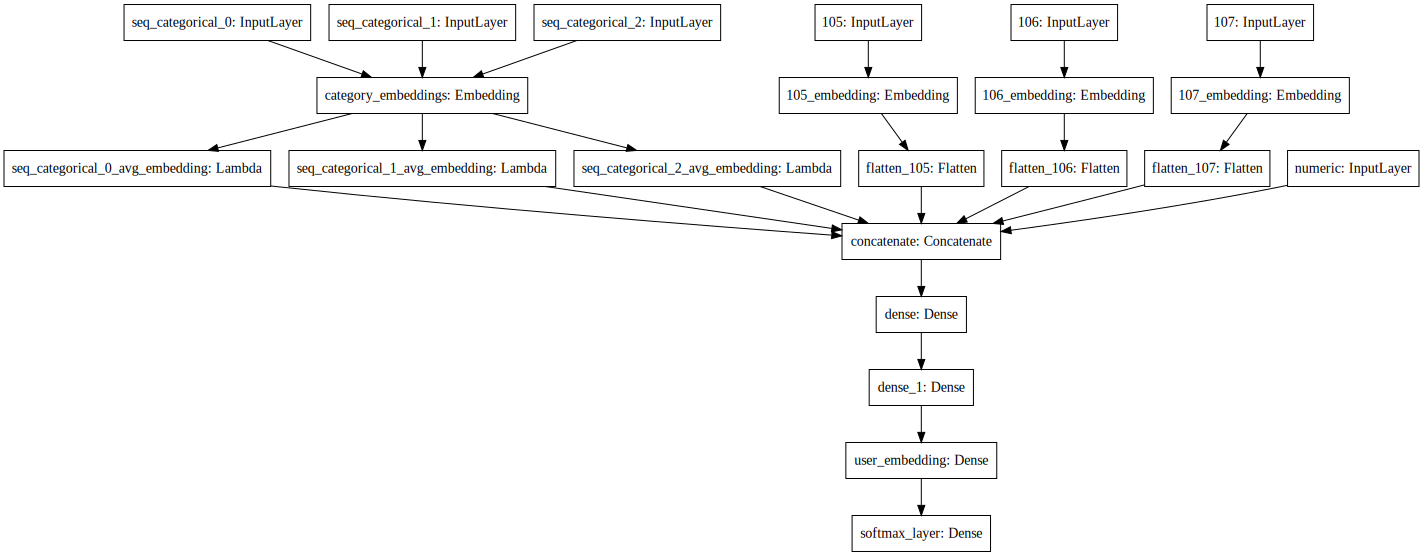

In [16]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [508]:
#%time model.fit(x=inputs, y=one_hot_labels, epochs=50, batch_size=32)

In [510]:
%time model.fit(ds3.make_one_shot_iterator(), epochs=50, steps_per_epoch=int(10000//32))

Epoch 1/50
312/312 [==============================] - 3s 10ms/step - loss: 4.5935 - acc: 0.0149
Epoch 2/50
312/312 [==============================] - 2s 5ms/step - loss: 4.5767 - acc: 0.0164
Epoch 3/50
312/312 [==============================] - 2s 5ms/step - loss: 4.5484 - acc: 0.0194
Epoch 4/50
312/312 [==============================] - 2s 5ms/step - loss: 4.5083 - acc: 0.0242
Epoch 5/50
312/312 [==============================] - 2s 5ms/step - loss: 4.4582 - acc: 0.0279
Epoch 6/50
312/312 [==============================] - 2s 5ms/step - loss: 4.4038 - acc: 0.0341
Epoch 7/50
312/312 [==============================] - 2s 5ms/step - loss: 4.3475 - acc: 0.0425
Epoch 8/50
312/312 [==============================] - 2s 5ms/step - loss: 4.2938 - acc: 0.0478
Epoch 9/50
312/312 [==============================] - 2s 5ms/step - loss: 4.2428 - acc: 0.0539
Epoch 10/50
312/312 [==============================] - 2s 5ms/step - loss: 4.1943 - acc: 0.0594
Epoch 11/50
312/312 [===========================

In [57]:
generator=data_generator.data_generator('../data/features.csv', 64, [50, 100, 150], [150,151,152], [153])


In [58]:
#generator=data_generator.DataGenerator('../data/features.csv', 10000, 64, 100, [50, 100, 150], [150,151,152], [153])

In [ ]:
%time model.fit_generator(generator,steps_per_epoch=10000//64, verbose=1, epochs=50, shuffle=True, use_multiprocessing=True, workers=15)
